In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as mso
import seaborn as sns
import warnings
import os
import scipy

from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
df = pd.read_csv("train_data_file.csv")
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
print(df.shape)

(614, 13)


In [4]:
df.Loan_ID.value_counts(dropna=False)

LP001002    1
LP002328    1
LP002305    1
LP002308    1
LP002314    1
           ..
LP001692    1
LP001693    1
LP001698    1
LP001699    1
LP002990    1
Name: Loan_ID, Length: 614, dtype: int64

In [5]:
df.Gender.value_counts(dropna=False)

Male      489
Female    112
NaN        13
Name: Gender, dtype: int64

In [8]:
df.Married.value_counts(dropna=False)

Yes    398
No     213
NaN      3
Name: Married, dtype: int64

In [11]:
df.Education.value_counts(dropna=False)

Graduate        480
Not Graduate    134
Name: Education, dtype: int64

In [14]:
df.Self_Employed.value_counts(dropna=False)

No     500
Yes     82
NaN     32
Name: Self_Employed, dtype: int64

In [17]:
df.Credit_History.value_counts(dropna=False)

1.0    475
0.0     89
NaN     50
Name: Credit_History, dtype: int64

In [20]:
df.Property_Area.value_counts(dropna=False)

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

In [26]:
df.Loan_Amount_Term.value_counts(dropna=False)

360.0    512
180.0     44
480.0     15
NaN       14
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

In [29]:
df[['ApplicantIncome','CoapplicantIncome','LoanAmount']].describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount
count,614.000000,614.000000,592.000000
mean,5403.459283,1621.245798,146.412162
std,6109.041673,2926.248369,85.587325
min,150.000000,0.000000,9.000000
25%,2877.500000,0.000000,100.000000
50%,3812.500000,1188.500000,128.000000
75%,5795.000000,2297.250000,168.000000
max,81000.000000,41667.000000,700.000000


Histogram Distribution

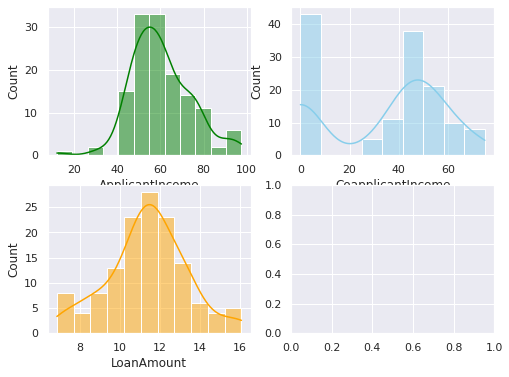

In [70]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(2, 2, figsize=(8,6))
sns.histplot(data=df, x="ApplicantIncome", kde=True, ax=axs[0, 0], color='green')
sns.histplot(data=df, x="CoapplicantIncome", kde=True, ax=axs[0, 1], color='skyblue')
sns.histplot(data=df, x="LoanAmount", kde=True, ax=axs[1, 0], color='orange');

Heatmap

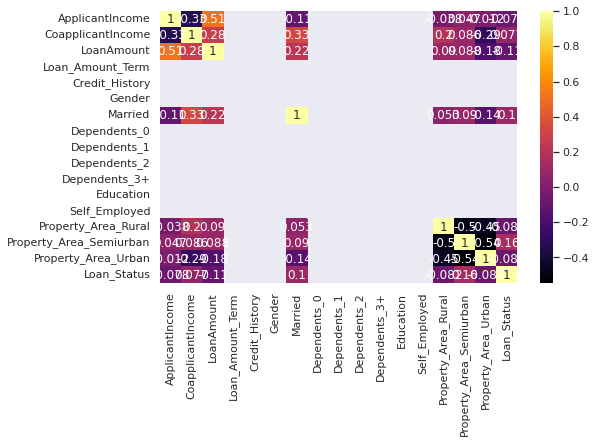

In [69]:
plt.figure(figsize=(8,5))
sns.heatmap(df.corr(), annot=True, cmap='inferno');

In [40]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [42]:
df = df.drop(['Loan_ID'], axis = 1)

In [ ]:
df['Gender'].fillna(df['Gender'].mode()[0],inplace=True)
df['Married'].fillna(df['Married'].mode()[0],inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0],inplace=True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0],inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0],inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0],inplace=True)

In [65]:
df['LoanAmount'].fillna(df['LoanAmount'].mean(),inplace=True)

In [45]:
df = pd.get_dummies(df)
# Drop columns
df = df.drop(['Gender_Female', 'Married_No', 'Education_Not Graduate', 'Self_Employed_No', 'Loan_Status_N'], axis = 1)
# Rename columns name
new = {'Gender_Male': 'Gender', 'Married_Yes': 'Married', 'Education_Graduate': 'Education', 'Self_Employed_Yes': 'Self_Employed','Loan_Status_Y': 'Loan_Status'}
df.rename(columns=new, inplace=True)

In [46]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [47]:
df.ApplicantIncome = np.sqrt(df.ApplicantIncome)
df.CoapplicantIncome = np.sqrt(df.CoapplicantIncome)
df.LoanAmount = np.sqrt(df.LoanAmount)

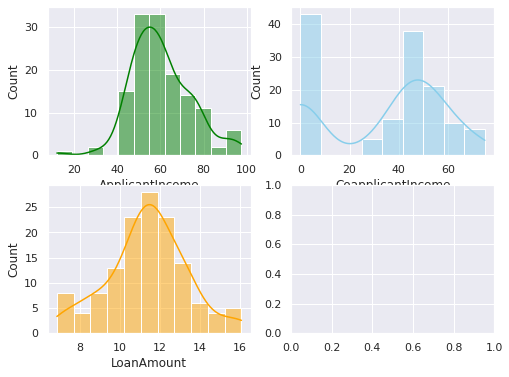

In [71]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
sns.histplot(data=df, x="ApplicantIncome", kde=True, ax=axs[0, 0], color='green')
sns.histplot(data=df, x="CoapplicantIncome", kde=True, ax=axs[0, 1], color='skyblue')
sns.histplot(data=df, x="LoanAmount", kde=True, ax=axs[1, 0], color='orange');

In [49]:
X = df.drop(["Loan_Status"], axis=1)
y = df["Loan_Status"]

In [ ]:
X, y = SMOTE().fit_resample(X, y)

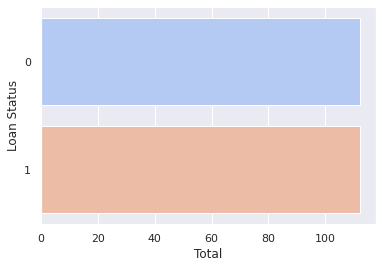

In [72]:
sns.set_theme(style="darkgrid")
sns.countplot(y=y, data=df, palette="coolwarm")
plt.ylabel('Loan Status')
plt.xlabel('Total')
plt.show()

In [52]:
X = MinMaxScaler().fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

Logistic Regression

In [54]:
LRclassifier = LogisticRegression(solver='saga', max_iter=500, random_state=1)
LRclassifier.fit(X_train, y_train)
y_pred = LRclassifier.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
from sklearn.metrics import accuracy_score
LRAcc = accuracy_score(y_pred,y_test)
print('LR accuracy: {:.2f}%'.format(LRAcc*100))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85        23
           1       0.86      0.82      0.84        22

    accuracy                           0.84        45
   macro avg       0.85      0.84      0.84        45
weighted avg       0.84      0.84      0.84        45

[[20  3]
 [ 4 18]]
LR accuracy: 84.44%


K-Nearest Neighbour (KNN)

In [ ]:
scoreListknn = []
for i in range(1,21):
    KNclassifier = KNeighborsClassifier(n_neighbors = i)
    KNclassifier.fit(X_train, y_train)
    scoreListknn.append(KNclassifier.score(X_test, y_test))
plt.plot(range(1,21), scoreListknn)
plt.xticks(np.arange(1,21,1))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()
KNAcc = max(scoreListknn)
print("KNN best accuracy: {:.2f}%".format(KNAcc*100))

Support Vector Machine (SVM)

In [56]:
SVCclassifier = SVC(kernel='rbf', max_iter=500)
SVCclassifier.fit(X_train, y_train)
y_pred = SVCclassifier.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
from sklearn.metrics import accuracy_score
SVCAcc = accuracy_score(y_pred,y_test)
print('SVC accuracy: {:.2f}%'.format(SVCAcc*100))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87        23
           1       0.86      0.86      0.86        22

    accuracy                           0.87        45
   macro avg       0.87      0.87      0.87        45
weighted avg       0.87      0.87      0.87        45

[[20  3]
 [ 3 19]]
SVC accuracy: 86.67%


Decision Tree

In [ ]:
scoreListDT = []
for i in range(2,21):
    DTclassifier = DecisionTreeClassifier(max_leaf_nodes=i)
    DTclassifier.fit(X_train, y_train)
    scoreListDT.append(DTclassifier.score(X_test, y_test))
plt.plot(range(2,21), scoreListDT)
plt.xticks(np.arange(2,21,1))
plt.xlabel("Leaf")
plt.ylabel("Score")
plt.show()
DTAcc = max(scoreListDT)
print("Decision Tree Accuracy: {:.2f}%".format(DTAcc*100))

Random Forest

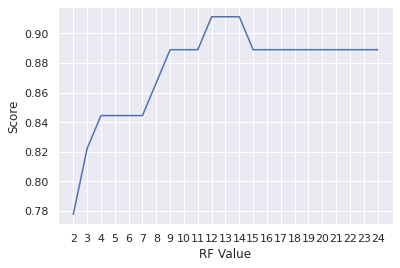

Random Forest Accuracy:  91.11%


In [60]:
scoreListRF = []
for i in range(2,25):
    RFclassifier = RandomForestClassifier(n_estimators = 1000, random_state = 1, max_leaf_nodes=i)
    RFclassifier.fit(X_train, y_train)
    scoreListRF.append(RFclassifier.score(X_test, y_test))
plt.plot(range(2,25), scoreListRF)
plt.xticks(np.arange(2,25,1))
plt.xlabel("RF Value")
plt.ylabel("Score")
plt.show()
RFAcc = max(scoreListRF)
print("Random Forest Accuracy:  {:.2f}%".format(RFAcc*100))

In [63]:
compare = pd.DataFrame({'Model': ['Logistic Regression', 'K Neighbors', 'SVM', 'Decision Tree', 'Random Forest', ], 'Accuracy': [LRAcc*100, KNAcc*100, SVCAcc*100, DTAcc*100, RFAcc*100]})
compare.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
4,Random Forest,91.111111
1,K Neighbors,88.888889
2,SVM,86.666667
3,Decision Tree,86.666667
0,Logistic Regression,84.444444
